In [409]:
# Import required libraries
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [406]:
# Set up Chrome WebDriver with headless option (no visible browser window)
chrome_options = Options()
chrome_options.add_argument("--headless")
driver_path = r"C:\Users\adeni\Shuttle_Websraper\chromedriver-win64\chromedriver.exe"
# Start the browser
chrome_service = ChromeService(executable_path=driver_path)
driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

In [407]:
# Target url
url = "https://stockanalysis.com/stocks/industry/software-infrastructure/"
driver.get(url)

# Wait for the cookie consent pop-up to appear and click the "Consent" button
try:
    consent_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//button[@class='fc-button fc-cta-consent fc-primary-button']")))
    consent_button.click()
except Exception as e:
    print("Cookie consent pop-up not found or could not be clicked.")

time.sleep(3)  # Give the page some time to load (you may adjust this delay if needed)

# Parse the dynamically loaded page source with BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')

# Find the table element by its ID
table_element = soup.find("table", {"id": "main-table"})

# Extract the table rows
table_rows = table_element.find_all("tr")

# Create empty lists to store the data
data = []
header_row = True

# Iterate over each row and extract the data
for row in table_rows:
    if header_row:
        header_row = False
        continue  # Skip the header row
    row_data = [cell.text.strip() for cell in row.find_all("td")]
    data.append(row_data)

# Close the web driver
driver.quit()

# Convert the data to a Pandas DataFrame
df = pd.DataFrame(data, columns=["No.", "Symbol", "Company Name", "Market Cap", "% Change", "Volume", "Revenue"])

# Print the DataFrame
df.head()

Cookie consent pop-up not found or could not be clicked.


,No.,Symbol,Company Name,Market Cap,% Change,Volume,Revenue
0,1,MSFT,Microsoft Corporation,"3,014.16B",-1.35%,"25,339,910",227.58B
1,2,ORCL,Oracle Corporation,319.95B,0.52%,"6,530,386",51.63B
2,3,ADBE,Adobe Inc.,284.99B,-0.67%,"2,130,652",19.41B
3,4,PANW,"Palo Alto Networks, Inc.",108.61B,-0.17%,"2,670,113",7.21B
4,5,SNPS,"Synopsys, Inc.",85.28B,1.28%,"1,237,042",5.84B


In [402]:
df.describe()

,No.,Symbol,Company Name,Market Cap,% Change,Volume,Revenue
count,139,139,139,139,139,139,139
unique,139,139,139,137,132,139,134
top,1,MSFT,Microsoft Corporation,6.55B,-,"25,338,344",-
freq,1,1,1,2,3,1,3


In [403]:
symbols = df['Symbol']
symbols

0      MSFT
1      ORCL
2      ADBE
3      PANW
4      SNPS
       ... 
134    INTZ
135    BCAN
136    NXTP
137    CETX
138    TAOP
Name: Symbol, Length: 139, dtype: object

In [411]:
driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

# Create an empty list to store data temporarily
all_data = []

for symbol in symbols:
    url = f"https://stockanalysis.com/stocks/{symbol}/financials/" # Target url for income_data
    driver.get(url)
    
    # Wait for the financials table to load
    WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.XPATH, "//table[@data-test='financials']")))

    # Parse the dynamically loaded page source with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Find the table element by its data-test attribute
    table_element = soup.find("table", {"data-test": "financials"})

    # Extract the table rows
    table_rows = []
    for row in table_element.select("tr"):
        row_data = [data.text for data in row.select("td")]
        table_rows.append(row_data)
    
    # Extract the column headers
    column_headers = [header.text for header in table_element.select("th")]

    # Append the financial data to all_data list with an additional "Symbol" column
    for row in table_rows[1:]:
        row.insert(0,symbol)
        all_data.append(row)

# Close the web driver
driver.quit()

# Convert the list of financial data to a Pandas DataFrame
income_df = pd.DataFrame(all_data)

income_df = income_df.iloc[:,:9]

# Rows to keep in the final result
rows_to_keep = ["Revenue", "Gross Profit", "Operating Income", "Interest Expense / Income", 
                "Pretax Income", "Net Income", "Shares Outstanding (Diluted)", "Dividend Per Share"]

# Remove leading and trailing spaces from the "Year" column values
income_df[1] = income_df[1].str.strip()

# Keep only the rows specified in rows_of_interest based on the "Year" column
income_df = income_df[income_df[1].isin(rows_to_keep)]

# Create column name variable
columns = ['Symbol', 'Metrics', '2022', '2021', '2020', '2019', '2018', '2017', '2016']

# Replace column names
income_df.columns = columns

# Reorder columns
income_df = income_df[income_df.columns[1:].tolist() + [income_df.columns[0]]]

# Reset the index of the DataFrame
income_df = income_df.reset_index(drop=True)

# Unpivot the income_df
income_df = pd.melt(income_df, id_vars = ['Symbol', 'Metrics'],
                     value_vars = ['2022', '2021', '2020', '2019',
                                   '2018', '2017', '2016'],
                    var_name = 'Years')

# Replace "-" with NaN
income_df['value'] = income_df['value'].replace({"-": np.nan})

# Convert value column to float
income_df['value'] = income_df['value'].str.replace(",","").astype(float)

# convert Years column to int
income_df['Years'] = income_df['Years'].astype(int)

# Print df
income_df.head()

,Symbol,Metrics,Years,value
0,MSFT,Revenue,2022,211915.0
1,MSFT,Gross Profit,2022,146052.0
2,MSFT,Operating Income,2022,88523.0
3,MSFT,Interest Expense / Income,2022,1968.0
4,MSFT,Pretax Income,2022,89311.0


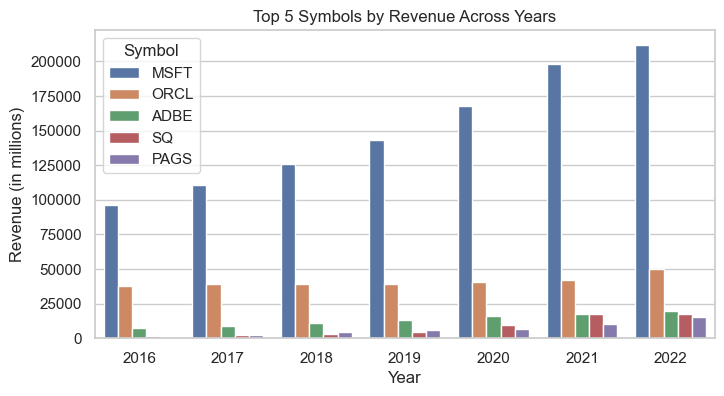

In [417]:
# Plot a bar chart to vies the revenue for each symbols in the df
revenue_data = income_df[income_df['Metrics'] == 'Revenue']

# Calculate total revenue for each symbol
total_revenue_per_symbol = revenue_data.groupby('Symbol')['value'].mean()

# Select the top 5 symbols based on total revenue
top5_symbols = total_revenue_per_symbol.nlargest(5).index

# Filter the original DataFrame to include only the top 5 symbols
filtered_revenue_data = revenue_data[revenue_data['Symbol'].isin(top5_symbols)]

# Create the bar plot
plt.figure(figsize=(8, 4))
sns.barplot(x='Years', y='value', hue='Symbol', data=filtered_revenue_data)
plt.title('Top 5 Symbols by Revenue Across Years')
plt.xlabel('Year')
plt.ylabel('Revenue (in millions)')
plt.show()


In [253]:
# Lets get the balance sheet data
driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

all_data = []

for symbol in symbols:
    url = f"https://stockanalysis.com/stocks/{symbol}/financials/balance-sheet/"
    driver.get(url)
    
    # Wait for the financials table to load
    WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.XPATH, "//table[@data-test='financials']")))

    # Parse the dynamically loaded page source with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Find the table element by its data-test attribute
    table_element = soup.find("table", {"data-test": "financials"})

    # Extract the table rows
    table_rows = []
    for row in table_element.select("tr"):
        row_data = [data.text for data in row.select("td")]
        table_rows.append(row_data)
    
    # Extract the column headers
    column_headers = [header.text for header in table_element.select("th")]

    # Append the financial data to all_data list with an additional "Symbol" column
    for row in table_rows[1:]:
        row.insert(0,symbol)
        all_data.append(row)

# Close the web driver
driver.quit()

# Convert the list of financial data to a Pandas DataFrame
columns = column_headers + ["Symbol"]
balancesheet_df = pd.DataFrame(all_data)

balancesheet_df = balancesheet_df.iloc[:,:9]

# Rows to keep in the final result
rows_to_keep = ["Receivables", "Inventory", "Total Current Assets", "Total Assets", "Accounts Payable",
                "Total Current Liabilities", "Total Liabilities", "Shareholders' Equity"]

# Remove leading and trailing spaces from the "Year" column values
balancesheet_df[1] = balancesheet_df[1].str.strip()

# Keep only the rows specified in rows_of_interest based on the "Year" column
balancesheet_df = balancesheet_df[balancesheet_df[1].isin(rows_of_interest)]

# Create column name variable
columns = ['Symbol', 'Metrics', '2022', '2021', '2020', '2019', '2018', '2017', '2016']

# Replace column names
balancesheet_df.columns = columns

# Reorder columns
balancesheet_df = balancesheet_df[balancesheet_df.columns[1:].tolist() + [balancesheet_df.columns[0]]]

# Reset the index of the DataFrame
balancesheet_df = balancesheet_df.reset_index(drop=True)

# Unpivot the income_df
balancesheet_df = pd.melt(balancesheet_df, id_vars = ['Symbol', 'Metrics'],
                     value_vars = ['2022', '2021', '2020', '2019',
                                   '2018', '2017', '2016'],
                    var_name = 'Years')

# Replace "-" with NaN
balancesheet_df['value'] = balancesheet_df['value'].replace({"-": np.nan})

# Convert value column to float
balancesheet_df['value'] = balancesheet_df['value'].str.replace(",","").astype(float)

# convert Years column to int
balancesheet_df['Years'] = balancesheet_df['Years'].astype(int)

# Print df
balancesheet_df

,Symbol,Metrics,Years,value
0,msft,Receivables,2022,48688.00
1,msft,Inventory,2022,2500.00
2,msft,Total Current Assets,2022,184257.00
3,msft,Total Assets,2022,411976.00
4,msft,Accounts Payable,2022,18095.00
...,...,...,...,...
7086,taop,Total Assets,2016,34.29
7087,taop,Accounts Payable,2016,9.04
7088,taop,Total Current Liabilities,2016,21.38
7089,taop,Total Liabilities,2016,21.48


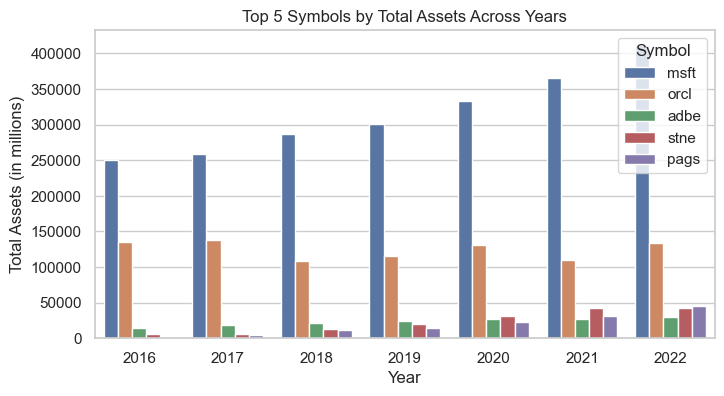

In [416]:
# Plot a bar chart to see the top 5 companies with Total Assets
revenue_data = balancesheet_df[balancesheet_df['Metrics'] == 'Total Assets']

# Calculate total revenue for each symbol
total_revenue_per_symbol = revenue_data.groupby('Symbol')['value'].mean()

# Select the top 5 symbols based on total revenue
top5_symbols = total_revenue_per_symbol.nlargest(5).index

# Filter the original DataFrame to include only the top 5 symbols
filtered_revenue_data = revenue_data[revenue_data['Symbol'].isin(top5_symbols)]

# Create the bar plot
plt.figure(figsize=(8, 4))
sns.barplot(x='Years', y='value', hue='Symbol', data=filtered_revenue_data)
plt.title('Top 5 Symbols by Total Assets Across Years')
plt.xlabel('Year')
plt.ylabel('Total Assets (in millions)')
plt.show()


In [266]:
# Lets get the cashflow statement data
driver_path = r"C:\Users\adeni\Shuttle_Websraper\chromedriver-win64\chromedriver.exe"
# Start the browser
chrome_service = ChromeService(executable_path=driver_path)
driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

all_data = []

for symbol in symbol_list:
    url = f"https://stockanalysis.com/stocks/{symbol}/financials/cash-flow-statement/"
    driver.get(url)
    
    # Wait for the financials table to load
    WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.XPATH, "//table[@data-test='financials']")))

    # Parse the dynamically loaded page source with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Find the table element by its data-test attribute
    table_element = soup.find("table", {"data-test": "financials"})

    # Extract the table rows
    table_rows = []
    for row in table_element.select("tr"):
        row_data = [data.text for data in row.select("td")]
        table_rows.append(row_data)
    
    # Extract the column headers
    column_headers = [header.text for header in table_element.select("th")]

    # Append the financial data to all_data list with an additional "Symbol" column
    for row in table_rows[1:]:
        row.insert(0,symbol)
        all_data.append(row)

# Close the web driver
driver.quit()

# Convert the list of financial data to a Pandas DataFrame
cashflow_df = pd.DataFrame(all_data)

cashflow_df = cashflow_df.iloc[:,:9]

# Rows to keep in the final result
rows_to_keep = ["Net Income", "Investing Cash Flow"]

# Remove leading and trailing spaces from the "Year" column values
cashflow_df[1] = cashflow_df[1].str.strip()

# Keep only the rows specified in rows_of_interest based on the "Year" column
cashflow_df = cashflow_df[cashflow_df[1].isin(rows_to_keep)]

# Create column name variable
columns = ['Symbol', 'Metrics', '2022', '2021', '2020', '2019', '2018', '2017', '2016']

# Replace column names
cashflow_df.columns = columns

# Reorder columns
cashflow_df = cashflow_df[cashflow_df.columns[1:].tolist() + [cashflow_df.columns[0]]]

# Reset the index of the DataFrame
cashflow_df = cashflow_df.reset_index(drop=True)

# Unpivot the income_df
cashflow_df = pd.melt(cashflow_df, id_vars = ['Symbol', 'Metrics'],
                     value_vars = ['2022', '2021', '2020', '2019',
                                   '2018', '2017', '2016'],
                    var_name = 'Years')

# Replace "-" with NaN
cashflow_df['value'] = cashflow_df['value'].replace({"-": np.nan})

# Convert value column to float
cashflow_df['value'] = cashflow_df['value'].str.replace(",","").astype(float)

# convert Years column to int
cashflow_df['Years'] = cashflow_df['Years'].astype(int)

# Print df
cashflow_df.head()

,Symbol,Metrics,Years,value
0,msft,Net Income,2022,72361.0
1,msft,Investing Cash Flow,2022,-22680.0
2,orcl,Net Income,2022,8503.0
3,orcl,Investing Cash Flow,2022,-36484.0
4,adbe,Net Income,2022,5428.0


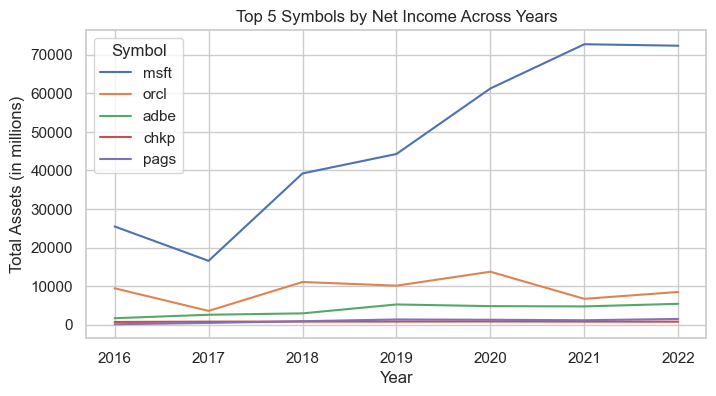

In [419]:
# Plot a line chart to see the top 5 companies with Total Assets
revenue_data = cashflow_df[cashflow_df['Metrics'] == 'Net Income']

# Calculate total revenue for each symbol
total_revenue_per_symbol = revenue_data.groupby('Symbol')['value'].mean()

# Select the top 5 symbols based on total revenue
top5_symbols = total_revenue_per_symbol.nlargest(5).index

# Filter the original DataFrame to include only the top 5 symbols
filtered_revenue_data = revenue_data[revenue_data['Symbol'].isin(top5_symbols)]

# Create the bar plot
plt.figure(figsize=(8, 4))
sns.lineplot(x='Years', y='value', hue='Symbol', data=filtered_revenue_data)
plt.title('Top 5 Symbols by Net Income Across Years')
plt.xlabel('Year')
plt.ylabel('Total Assets (in millions)')
plt.show()

In [269]:
# Combine the 3 dataframes together 
combined_df = pd.concat([income_df, cashflow_df, balancesheet_df],
                        ignore_index=True)

combined_df

,Symbol,Metrics,Years,value
0,msft,Revenue,2022,211915.00
1,msft,Gross Profit,2022,146052.00
2,msft,Operating Income,2022,88523.00
3,msft,Interest Expense / Income,2022,1968.00
4,msft,Pretax Income,2022,89311.00
...,...,...,...,...
15703,taop,Total Assets,2016,34.29
15704,taop,Accounts Payable,2016,9.04
15705,taop,Total Current Liabilities,2016,21.38
15706,taop,Total Liabilities,2016,21.48


In [307]:
combined_df['Metrics']

0                          Revenue
1                     Gross Profit
2                 Operating Income
3        Interest Expense / Income
4                    Pretax Income
                   ...            
15703                 Total Assets
15704             Accounts Payable
15705    Total Current Liabilities
15706            Total Liabilities
15707         Shareholders' Equity
Name: Metrics, Length: 15708, dtype: object

In [392]:
# Get a copy of the combined data
industry_avg_data = combined_df.copy()

# Convert the 'value' column to numeric (assuming it contains numerical values)
industry_avg_data['value'] = pd.to_numeric(industry_avg_data['value'])

# Pivot the data to get the industry average for each metric and year
industry_avg_pivot = pd.pivot_table(industry_avg_data, values='value', index=['Metrics'], columns=['Years'], aggfunc='mean')

# Print the resulting DataFrame
industry_avg_pivot

Years,2016,2017,2018,2019,2020,2021,2022
Metrics,,,,,,,
Accounts Payable,236.883077,278.401463,286.740440,285.276746,384.243185,514.107554,569.659493
Dividend Per Share,1.627500,0.894000,0.931000,1.061600,4.296333,1.177857,1.198333
Gross Profit,1618.279125,1797.184819,1713.366800,1521.661562,1659.960735,1903.031151,2154.136619
Interest Expense / Income,74.645429,88.593699,79.553933,67.037364,69.433333,75.256750,121.327250
Inventory,89.514000,104.129333,78.596667,69.057561,81.960682,108.243333,83.921556
Investing Cash Flow,-1071.437625,-323.234578,-32.006600,-64.869922,-500.623603,-337.162246,-623.848261
Net Income,452.717875,316.098735,563.784300,479.979844,570.435699,552.209640,568.659856
Operating Income,581.425125,679.750361,652.013900,607.445781,698.439779,743.256763,797.704676
Pretax Income,556.870625,669.185301,637.332700,574.239922,657.412794,662.365468,715.419353


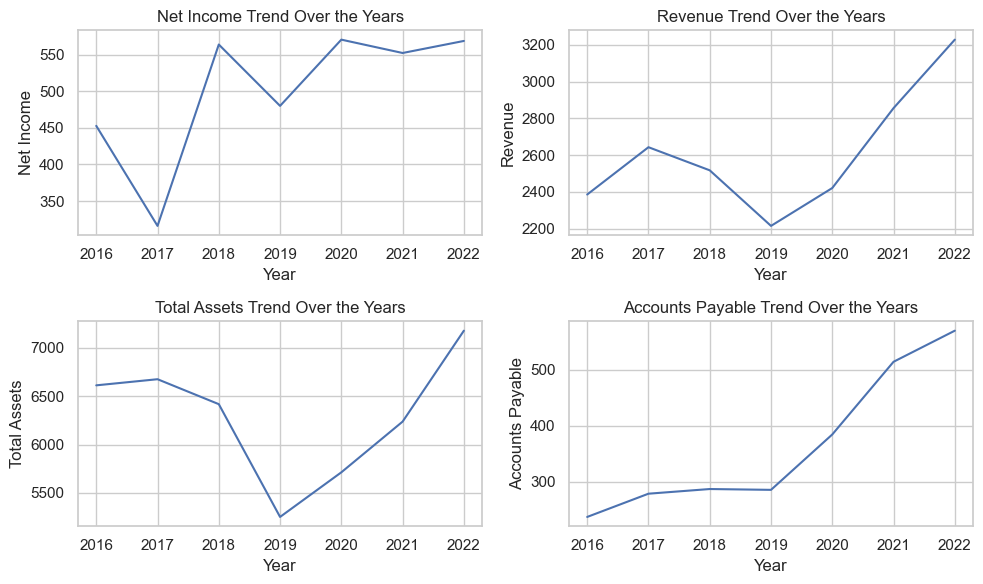

In [465]:
# Plotting some graphs from our metrics data

# Filter data for each metric
metrics_to_plot = ['Net Income', 'Revenue', 'Total Assets', 'Accounts Payable']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each metric
for i, metric in enumerate(metrics_to_plot):
    metric_data = combined_df[combined_df['Metrics'] == metric]
    metric_data = metric_data.groupby('Years')['value'].mean()
    sns.lineplot(data=metric_data, ax=axes[i])
    axes[i].set_title(f'{metric} Trend Over the Years')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel(metric)

# Adjust layout
plt.tight_layout()
plt.show()


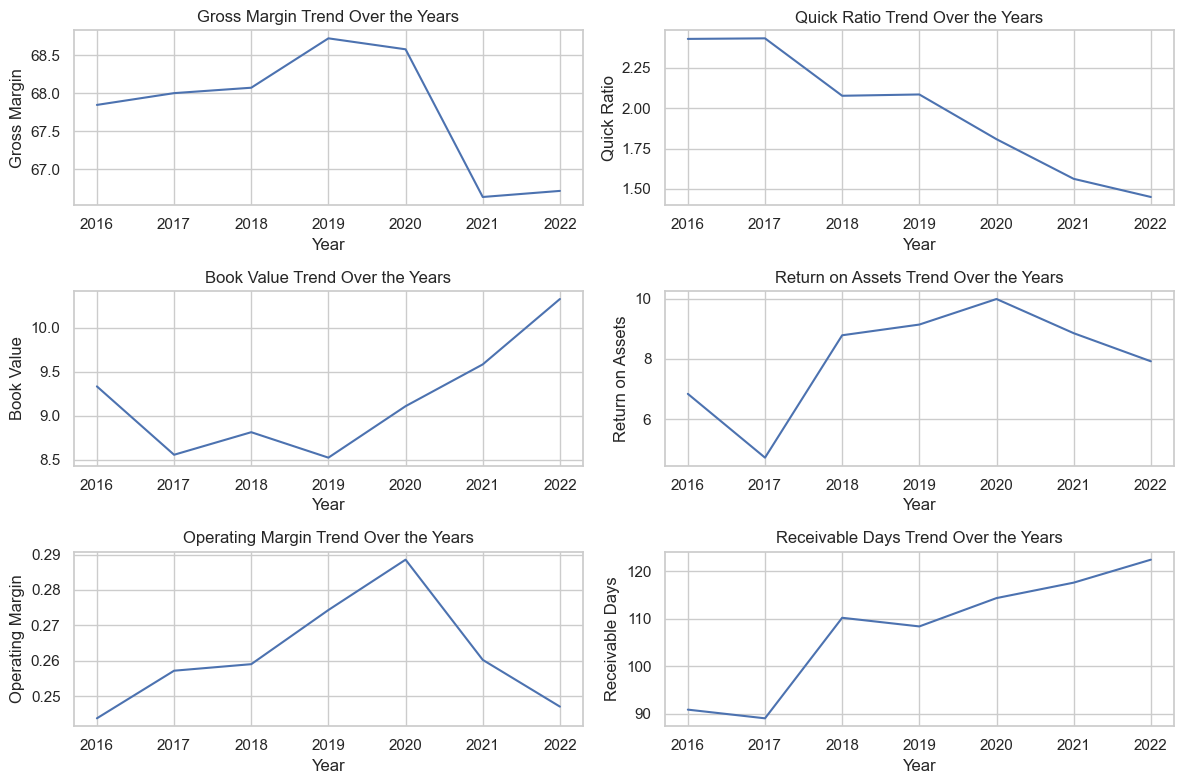

In [485]:
# Lets plot some ratios from our data

# Filter data for each metric
metrics_to_plot = ['Gross Margin', 'Quick Ratio', 'Book Value',
                   'Return on Assets', 'Operating Margin', 'Receivable Days']

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each metric
for i, metric in enumerate(metrics_to_plot):
    if metric == 'Gross Margin':
        gross_profit_data = combined_df[combined_df['Metrics'] == 'Gross Profit']
        revenue_data = combined_df[combined_df['Metrics'] == 'Revenue']
        gross_profit_data = gross_profit_data.groupby('Years')['value'].mean()
        revenue_data = revenue_data.groupby('Years')['value'].mean()
        gross_margin = (gross_profit_data / revenue_data) * 100
        sns.lineplot(data=gross_margin, ax=axes[i])
    elif metric == 'Quick Ratio':
        current_data = combined_df[combined_df['Metrics'] == 'Total Current Assets']
        liability_data = combined_df[combined_df['Metrics'] == 'Total Current Liabilities']
        inventory_data = combined_df[combined_df['Metrics'] == 'Inventory']
        current_data = current_data.groupby('Years')['value'].mean()
        liability_data = liability_data.groupby('Years')['value'].mean()
        inventory_data = inventory_data.groupby('Years')['value'].mean()
        quick_ratio = (current_data - inventory_data) / liability_data
        sns.lineplot(data=quick_ratio, ax=axes[i])
    elif metric == 'Return on Assets':
        net_income_data = combined_df[combined_df['Metrics'] == 'Net Income']
        total_assets_data = combined_df[combined_df['Metrics'] == 'Total Assets']
        net_income_data = net_income_data.groupby('Years')['value'].mean()
        total_assets_data = total_assets_data.groupby('Years')['value'].mean()
        return_on_assets = (net_income_data / total_assets_data) * 100
        sns.lineplot(data=return_on_assets, ax=axes[i])
    elif metric == 'Operating Margin':
        operating_data = combined_df[combined_df['Metrics'] == 'Operating Income']
        revenue_data = combined_df[combined_df['Metrics'] == 'Revenue']
        operating_data = operating_data.groupby('Years')['value'].mean()
        revenue_data = revenue_data.groupby('Years')['value'].mean()
        operating_margin = operating_data/revenue_data
        sns.lineplot(data=operating_margin, ax=axes[i])
    elif metric == 'Receivable Days':
        receivable_data = combined_df[combined_df['Metrics'] == 'Receivables']
        revenue_data = combined_df[combined_df['Metrics'] == 'Revenue']
        receivable_data = receivable_data.groupby('Years')['value'].mean()
        revenue_data = revenue_data.groupby('Years')['value'].mean()
        receivable_days = (receivable_data/revenue_data) * 360
        sns.lineplot(data=receivable_days, ax=axes[i])
    elif metric == 'Book Value':
        equity_data = combined_df[combined_df['Metrics'] == "Shareholders' Equity"]
        shares_outstanding_data = combined_df[combined_df['Metrics'] == 'Shares Outstanding (Diluted)']
        equity_data = equity_data.groupby('Years')['value'].mean()
        shares_outstanding_data = shares_outstanding_data.groupby('Years')['value'].mean()
        book_value = equity_data/shares_outstanding_data
        sns.lineplot(data=book_value, ax=axes[i])
        

    axes[i].set_title(f'{metric} Trend Over the Years')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel(metric)

# Adjust layout
plt.tight_layout()
plt.show()


In [488]:
print('ROA:',return_on_assets)
print('quick ratio:',quick_ratio)
print('Gross Margin:',gross_margin)
print('Book Value:',book_value)
print('Account Receivable Days:',receivable_days)
print('Operating Marging:',operating_margin)

ROA: Years
2016    6.846051
2017    4.734803
2018    8.784126
2019    9.138145
2020    9.983511
2021    8.852517
2022    7.922523
Name: value, dtype: float64
quick ratio: Years
2016    2.430347
2017    2.433799
2018    2.077331
2019    2.085446
2020    1.807819
2021    1.561785
2022    1.449086
Name: value, dtype: float64
Gross Margin: Years
2016    67.847165
2017    68.001827
2018    68.072825
2019    68.721027
2020    68.577175
2021    66.638654
2022    66.718439
Name: value, dtype: float64
Book Value: Years
2016     9.331884
2017     8.555342
2018     8.811613
2019     8.522516
2020     9.107170
2021     9.581797
2022    10.324509
Name: value, dtype: float64
Account Receivable Days: Years
2016     90.897544
2017     89.069054
2018    110.229592
2019    108.412524
2020    114.376729
2021    117.626947
2022    122.461087
Name: value, dtype: float64
Operating Marging: Years
2016    0.243765
2017    0.257204
2018    0.259048
2019    0.274334
2020    0.288543
2021    0.260267
2022    0.2